In [5]:
import pandas as pd
import os
import sys
import clumpsptm
import pymol
from tqdm import tqdm
import glob
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import ast

## 1. Aggregate Result Files
---

In [14]:
results_df = list()

for file in tqdm(glob.glob("clumpsptm_runs/**/*.tsv")):
    _df = pd.read_csv(file, sep='\t', index_col=0)
    _df['id'] = file.split('/')[1]
    results_df.append(_df)
    
results_df = pd.concat(results_df)

100%|██████████| 28/28 [00:03<00:00,  8.69it/s]


In [167]:
# Highlight any hits that are derived from a singular peptide
df = pd.read_csv("ref_uniprot_072522/full_mapped_sites_to_pdbs.tsv", sep='\t', index_col=0)
acc_var_df = df[['accession_number','variableSites']].reset_index().set_index("accession_number").drop_duplicates()

def traceback_peptide3s(row):
    """Traceback peptide 3s"""
    from ast import literal_eval
    
    if row['clumpsptm_input_n'] != 3:
        return None
    else:
        vs3 = {x if len(x.split(" ")) == 3 else None for x in literal_eval(row['variableSites'])}.pop()
        try:
            return acc_var_df[acc_var_df['variableSites']==vs3].loc[row.name]['id']
        except:
            return None

In [129]:
results_df['trace3s'] = results_df.apply(traceback_peptide3s,1).values

In [138]:
results_df.to_csv("CPTAC_PanCan_clumpsptm_output.tsv", sep="\t")

In [148]:
print(results_df[(results_df['clumpsptm_pval']<0.1) & (results_df['trace3s'].notna())].shape)
print(results_df[(results_df['clumpsptm_pval']<0.1) & (results_df['trace3s'].isna())].shape)

print(results_df[(results_df['fdr_corr']<0.1) & (results_df['trace3s'].notna())].shape)
print(results_df[(results_df['fdr_corr']<0.1) & (results_df['trace3s'].isna())].shape)

(265, 26)
(3371, 26)
(77, 26)
(255, 26)


In [139]:
results_df[
    (results_df['id']=='dendro_1_positive') &
    (results_df['fdr_corr'] < 0.1) &
    (results_df['clumpsptm_sampler']=='acetylome')
].sort_values('fdr_corr').head(10)

,geneSymbol,uniprot,pdb,chain,clumpsptm_sampler,clumpsptm_niter,clumpsptm_pval,clumpsptm_input,clumpsptm_sample,variableSites,...,value,clumpsptm_input_n,clumpsptm_sample_n,y,clumpsptm_fdr,fdr_max_pval,fdr_pass,fdr_corr,id,trace3s
accession_number,,,,,,,,,,,,,,,,,,,,,
NP_006006.3,ARID1A,O14497,6lth,L,acetylome,10000,0.00018,1808+1811+1815+1819,1654+1662+1677+1732+1804+1808+1811+1815+1819+1...,"['K1808k', 'K1811k', 'K1815k', 'K1819k']",...,"[0.0557573357377864, 0.5712053217914693, 0.011...",4,22,NP_006006.3 | ARID1A,0.08532,0.000137,True,0.08532,dendro_1_positive,None


## 2. Create DotPlots
---

In [3]:
def plot_pair(group, results_df, n_to_plot=20):
    """Plot paring."""
    fig, axes = plt.subplots(2, 2, figsize=(10,14))
    
    for j,feature in enumerate(['acetylome','phosphoproteome']):
        for i,direction in enumerate(['negative','positive']):
            _df = results_df[results_df['id']=="{}_{}".format(group, direction)]
            clumpsptm.vis.dotplot(
                _df.loc[_df[_df['clumpsptm_sampler']==feature].sort_values(
                    "clumpsptm_pval").iloc[:n_to_plot,:].index],
                sort_by=feature,
                x='clumpsptm_pval',
                ax=axes[i,j],
                thresh=0.1,
            )
            
            axes[i,j].legend().remove()
            axes[i,j].set_yticklabels(axes[i,j].get_yticklabels(), fontsize=14)
            axes[i,j].set_xlabel(r"$-log_{10}$ p-value", fontsize=16)
            
            if direction=='positive': direction = "(+)"
            if direction=='negative': direction = "(-)"
                
            axes[i,j].set_title("{} {}".format(feature.capitalize(), direction), fontsize=18)
            axes[i,j].set_yticklabels(axes[i,j].get_yticklabels(), fontsize=14)

    plt.suptitle(group, x=0.55, y=1.025, fontsize=20)
    plt.tight_layout()

In [4]:
os.makedirs('figures', exist_ok=True)
os.makedirs('figures/pymol', exist_ok=True)
os.makedirs('figures/dotplots', exist_ok=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


No Nominal P-Values < 0.1
No Nominal P-Values < 0.1


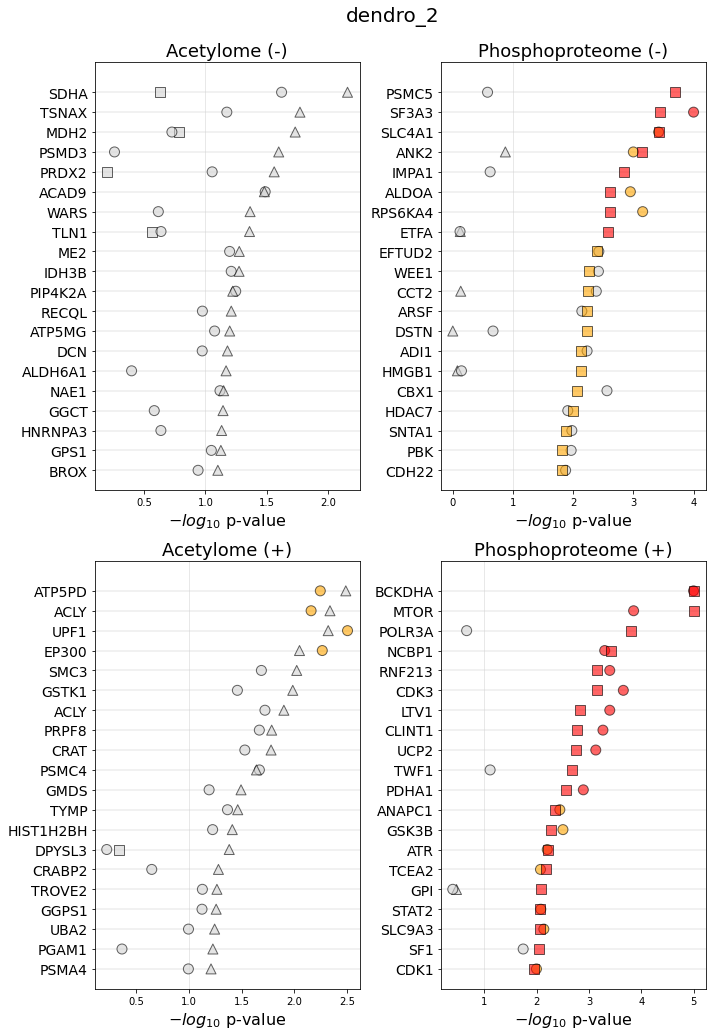

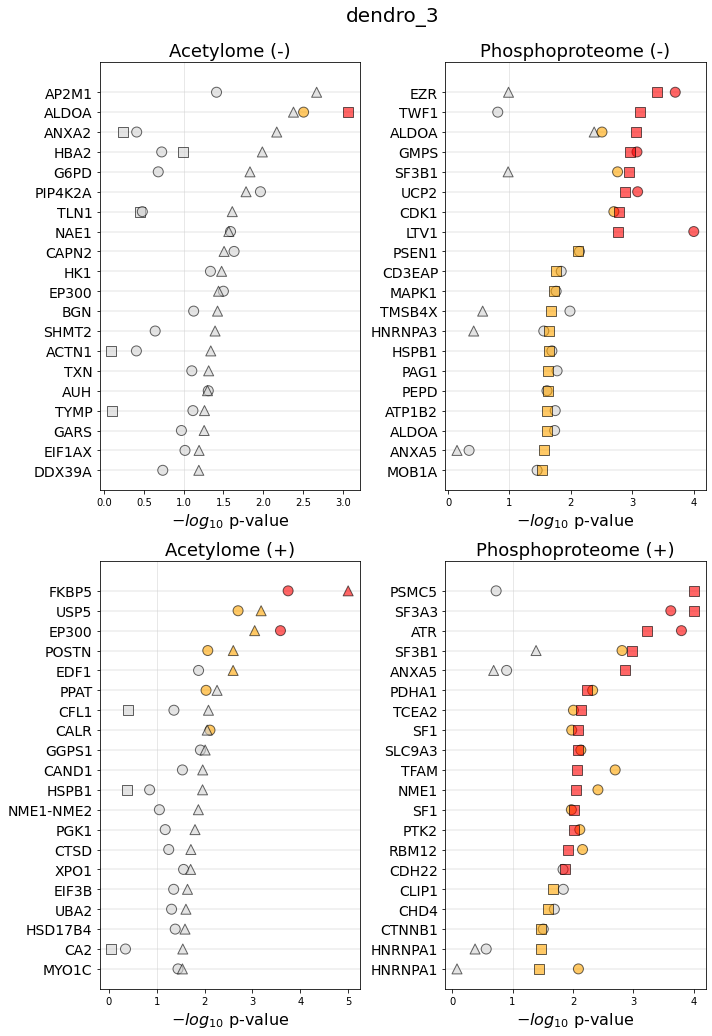

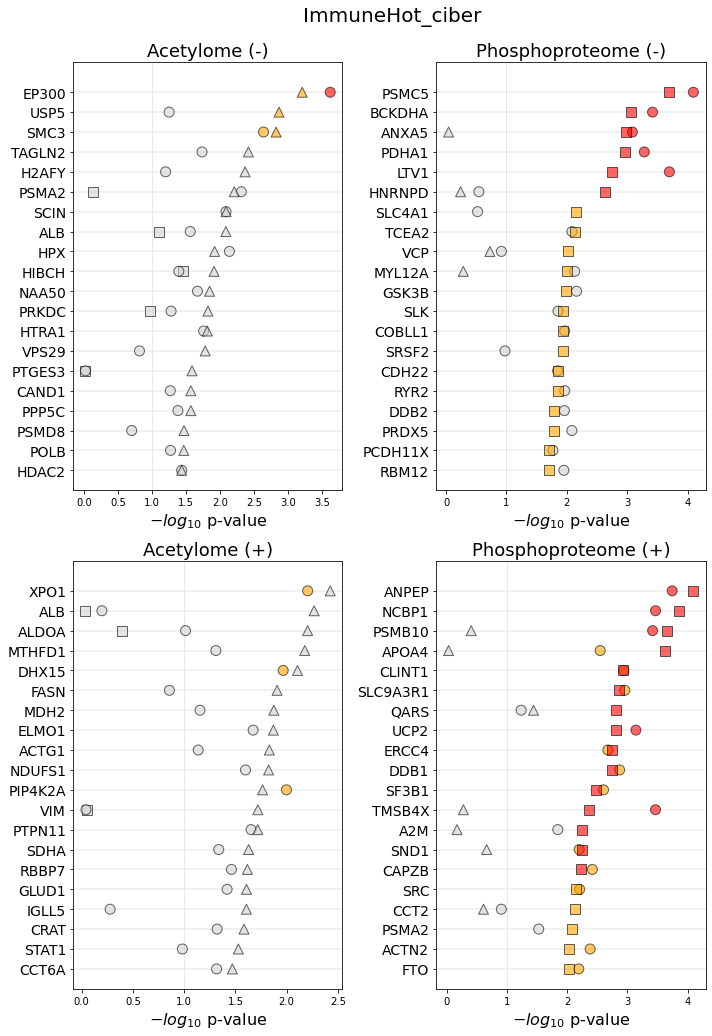

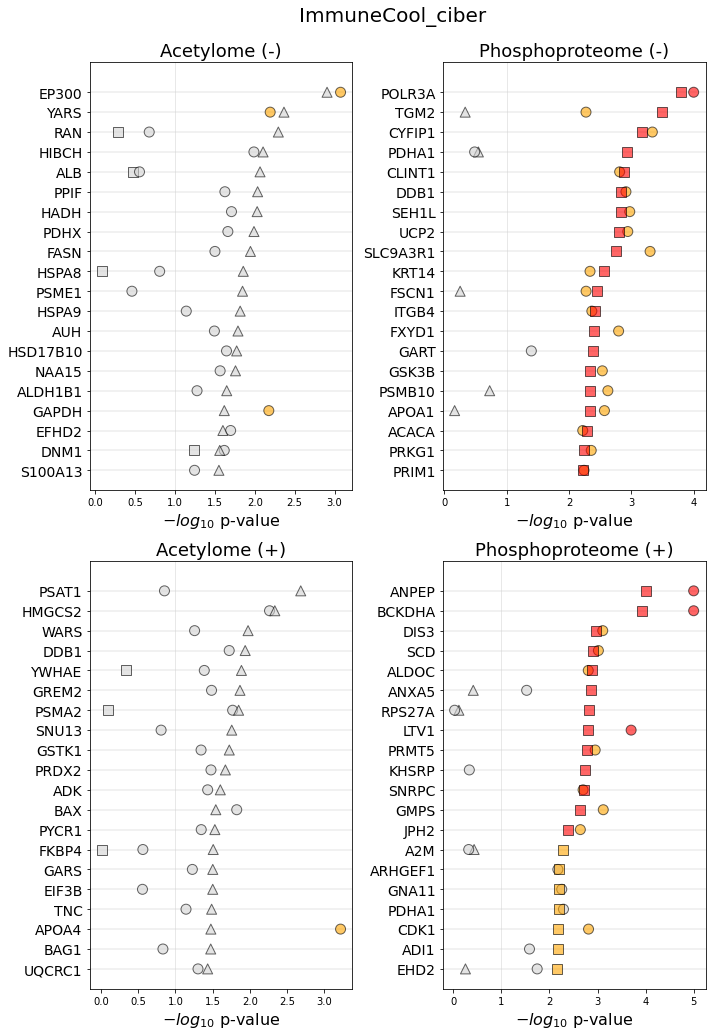

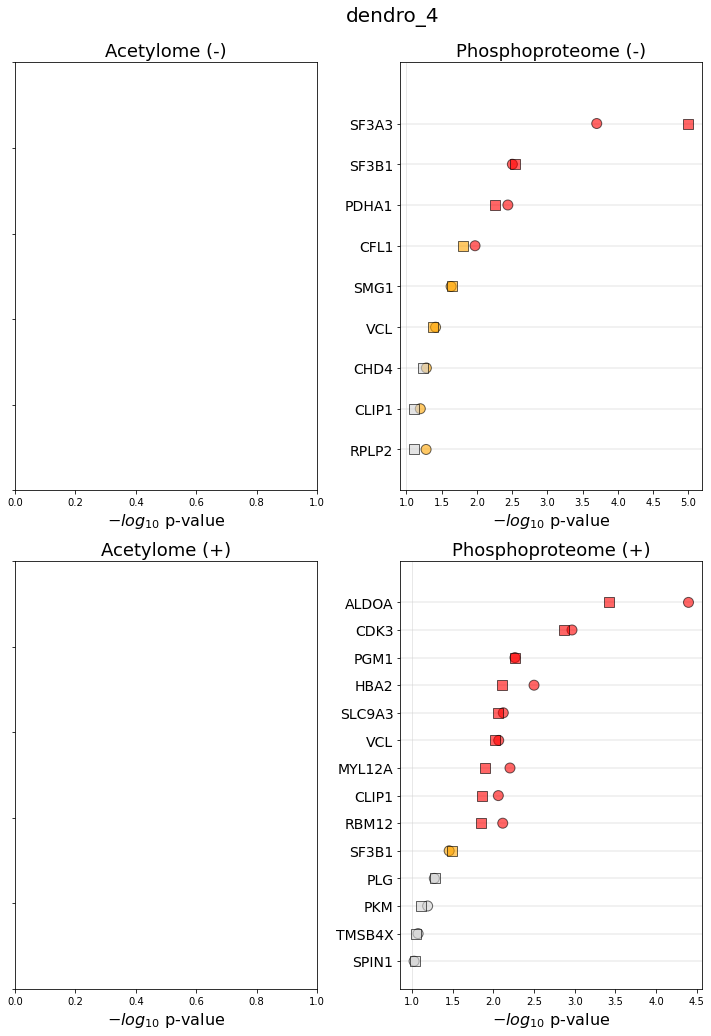

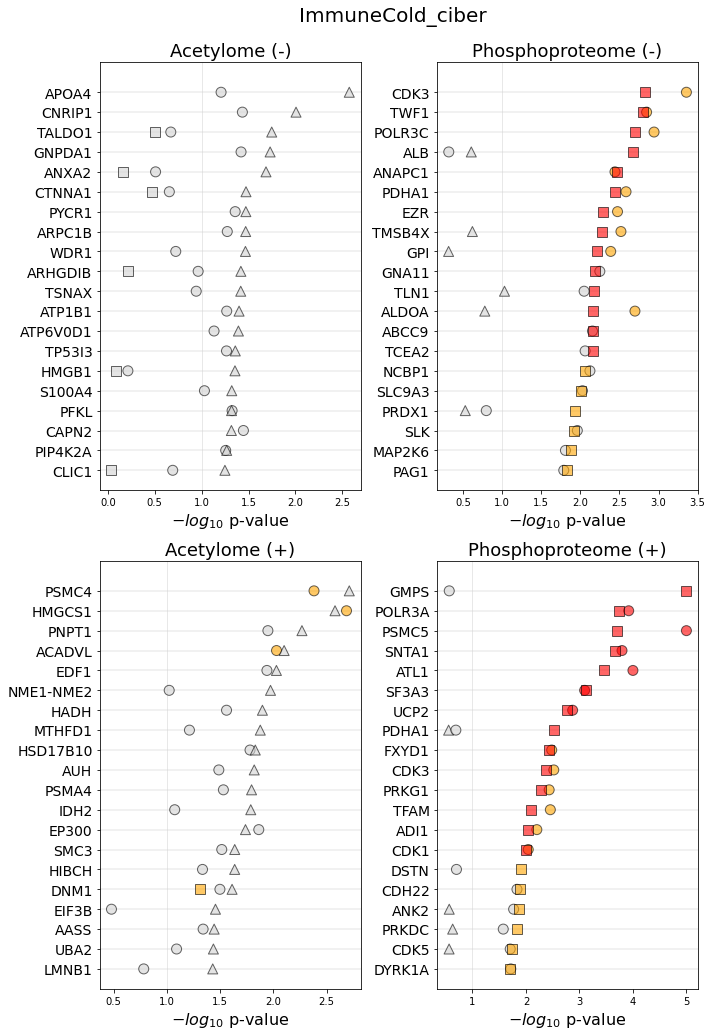

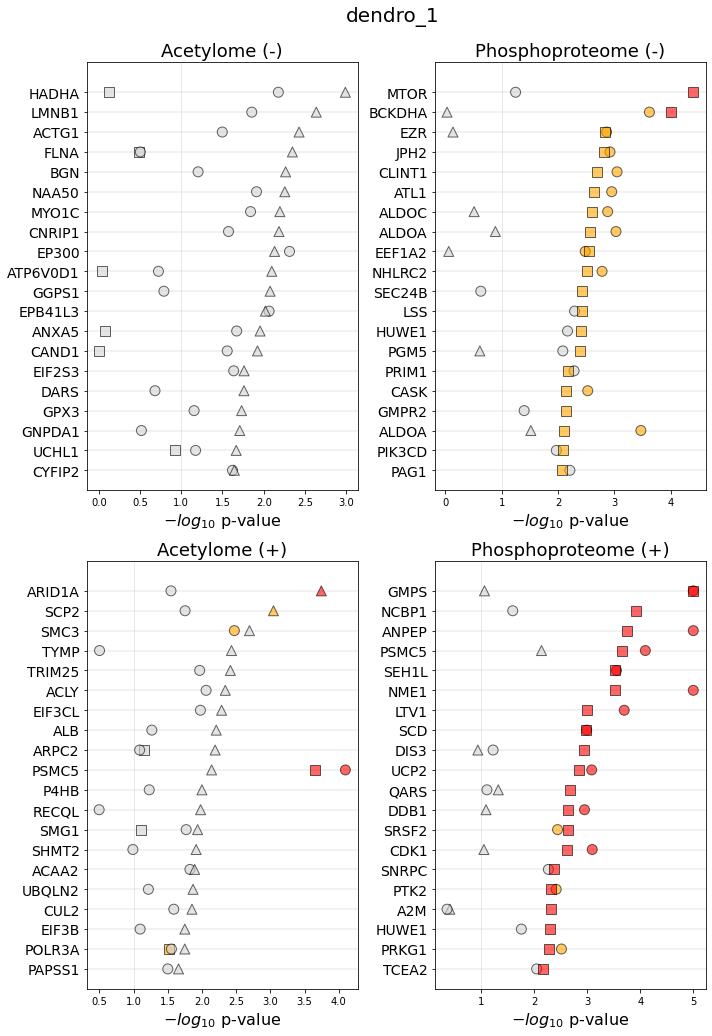

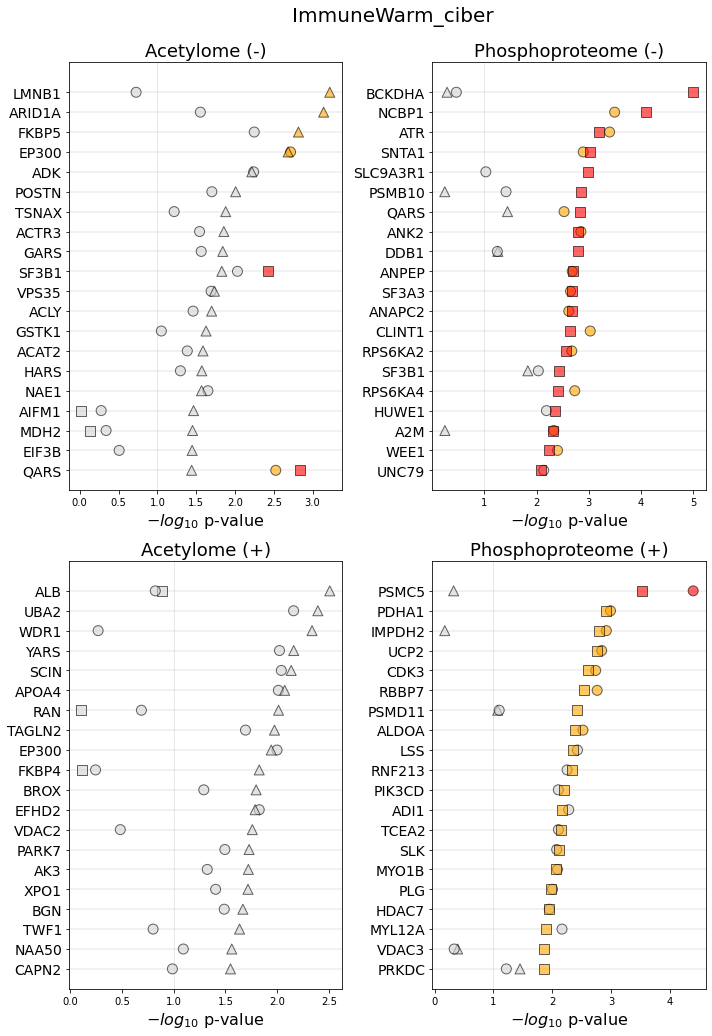

In [5]:
for group in {x.replace("_negative","").replace("_positive","") for x in np.unique(results_df['id'])}:
    plot_pair(group, results_df)
    plt.savefig(os.path.join("figures/dotplots", "{}_dotplot.pdf".format(group)), dpi=300, bbox_inches='tight')

In [ ]:
for group in np.unique(results_df['id']):
    os.makedirs(os.path.join('figures/pymol', group), exist_ok=True)
    
    for feat in np.unique(results_df['clumpsptm_sampler']):
        _df = results_df[(results_df['id']==group) & 
                         (results_df['clumpsptm_sampler']==feat)
                        ].sort_values('clumpsptm_pval').reset_index()
        _df.index = _df.index.astype(str)
        _out_dir = os.path.join('figures/pymol',group,feat)
        clumpsptm.vis.create_pymols_from_result(_df, out_dir=_out_dir, include_idx_in_name=True)

 89%|████████▉ | 42/47 [01:57<00:08,  1.67s/it]

In [183]:
def color_axes(ax, match_list, color='red'):
    """Color axes labels."""
    
    for lab in ax.get_yticklabels():
        if lab.get_text() in match_list:
            lab.set_color(color)

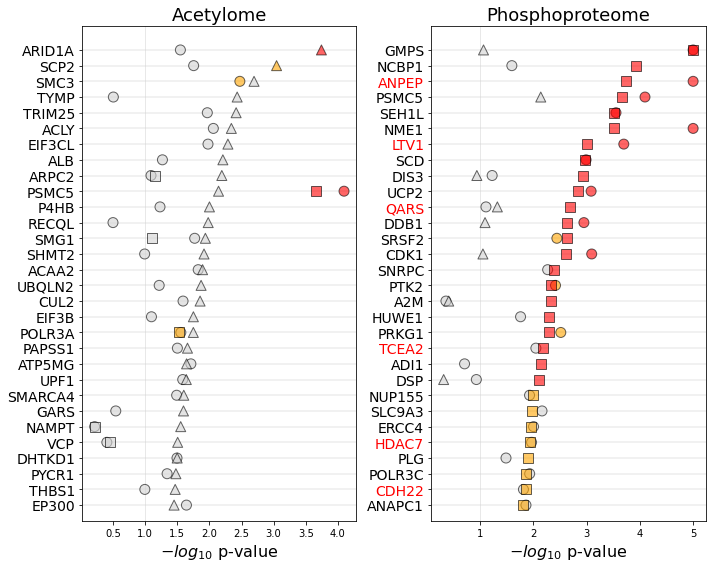

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(10,8))

n_to_plot = 30

_df = results_df[results_df['id']=="dendro_1_positive"]
_df_acetylome = _df.loc[_df[_df['clumpsptm_sampler']=="acetylome"].sort_values("clumpsptm_pval").iloc[:n_to_plot,:].index]
clumpsptm.vis.dotplot(
    _df_acetylome,
    sort_by="acetylome",
    x='clumpsptm_pval',
    ax=axes[0],
    thresh=0.1,
)

_df_phosphoproteome = _df.loc[_df[_df['clumpsptm_sampler']=="phosphoproteome"].sort_values("clumpsptm_pval").iloc[:n_to_plot,:].index]
clumpsptm.vis.dotplot(
    _df_phosphoproteome,
    sort_by="phosphoproteome",
    x='clumpsptm_pval',
    ax=axes[1],
    thresh=0.1,
)

axes[0].legend().remove()
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14)
axes[0].set_xlabel(r"$-log_{10}$ p-value", fontsize=16)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14)
axes[0].set_title("Acetylome", fontsize=18)

axes[1].legend().remove()
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=14)
axes[1].set_xlabel(r"$-log_{10}$ p-value", fontsize=16)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=14)
axes[1].set_title("Phosphoproteome", fontsize=18)

# Highlight triple peptide classes
_acetyl_trace3 = _df_acetylome[
    (_df_acetylome['clumpsptm_sampler']=='acetylome') & 
    (_df_acetylome['trace3s'].notna())]['geneSymbol'].values

_phospho_trace3 = _df_phosphoproteome[
    (_df_phosphoproteome['clumpsptm_sampler']=='phosphoproteome') & 
    (_df_phosphoproteome['trace3s'].notna())]['geneSymbol'].values

color_axes(axes[0], _acetyl_trace3)
color_axes(axes[1], _phospho_trace3)

plt.tight_layout()
plt.savefig("figures/dendro1_fig2.pdf", dpi=300, bbox_inches='tight')

## Figure S2E
---

In [6]:
sites_df = pd.read_csv("ref_uniprot_072522/full_mapped_sites_to_pdbs.tsv", sep='\t', index_col=0)
acc_df = pd.read_csv("ref_uniprot_072522/mapped_accession_to_sifts.tsv", sep="\t", index_col=0)

In [ ]:
def _label(row):
    if row['uniprot_match'] and row['pdb_res_match']:
        return "Mapped PDB Site"
    elif row['uniprot_match']:
        return "Mapped to Uniprot"
    else:
        return "Unmapped"
    
def _label_prot(row):
    x = set(sites_df[sites_df['accession_number']==row.name]['lab'])
    if 'Mapped PDB Site' in x:
        return "Mapped"
    else:
        return "Unmapped"
    
sites_df['lab'] = sites_df.apply(_label,1)
acc_df['lab'] = acc_df.apply(_label_prot,1)

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(4,8))

_ = pl.plot_strip(
    acc_df[["relIdentity"]].T, 
    acc_df['lab'], 
    yax="relIdentity",
    alpha=0.01,
    ylim=(0,1.25),
    figsize=(4,4),
    format_fig=True,
    ax=axes[0],
    color=['pink','#C1E1C1'],
    rasterized=True
)

axes[0].set_xticklabels(['Unmapped','Mapped'], fontsize=14)
axes[0].set_ylabel("Blastp+ Similiarity", fontsize=16)
axes[0].set_xlabel("")

_ = pl.plot_strip(
    sites_df[sites_df['acc_res'].notna()][["relIdentity"]].T, 
    sites_df[sites_df['acc_res'].notna()]['lab'], yax="relIdentity",
    alpha=0.01,
    ylim=(0,1.25),
    figsize=(4,4),
    format_fig=True,
    order=['Unmapped','Mapped to Uniprot','Mapped PDB Site'],
    ax=axes[1],
    color=['pink','#FAC898','#C1E1C1'],
    rasterized=True
)

axes[1].set_xticklabels(['Unmapped','Mapped to Uniprot', 'Mapped to PDB'], 
                        fontsize=14, rotation=45, ha='right')
axes[1].set_ylabel("Blastp+ Similiarity", fontsize=16)
axes[1].set_xlabel("")
plt.savefig("figures/clumpsptm_mapping_figs2e.pdf", dpi=300, bbox_inches='tight')

## Figure S2F
---

In [239]:
to_plot = [
    'ImmuneCold_ciber_negative',
    'ImmuneCold_ciber_positive',
    'ImmuneCool_ciber_negative',
    'ImmuneCool_ciber_positive',
    'ImmuneHot_ciber_negative',
    'ImmuneHot_ciber_positive',
    'ImmuneWarm_ciber_negative',
    'ImmuneWarm_ciber_positive',
    'dendro_1_negative',
    'dendro_1_positive',
    'dendro_2_negative',
    'dendro_2_positive',
    'dendro_3_negative',
    'dendro_3_positive',
]

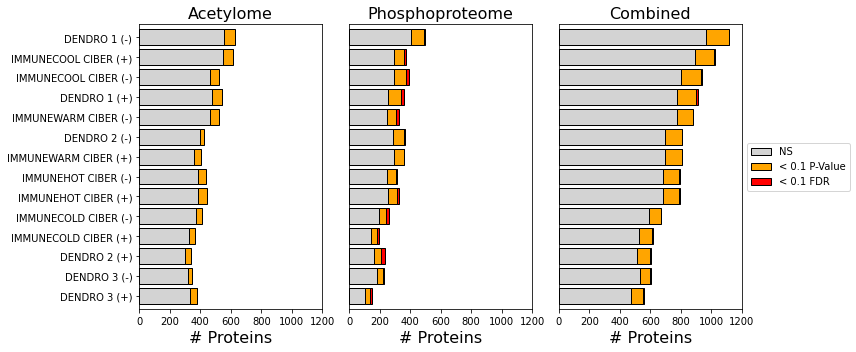

In [240]:
# ### Summary Figure
results_filt_df = results_df[results_df['id'].isin(to_plot)]

counts_df = results_filt_df.groupby(['id','clumpsptm_sampler']).size().reset_index().set_index(["id","clumpsptm_sampler"])
counts_df.columns = ['NS']

counts_pval_df = results_df[results_df['clumpsptm_pval']<0.1].groupby(['id','clumpsptm_sampler']).size().reset_index().set_index(["id","clumpsptm_sampler"])
counts_pval_df.columns = ['< 0.1 P-Value']

counts_fdr_df = results_df[results_df['fdr_corr']<0.1].groupby(['id','clumpsptm_sampler']).size().reset_index().set_index(["id","clumpsptm_sampler"])
counts_fdr_df.columns = ['< 0.1 FDR']

counts_df = counts_df.join(counts_pval_df).join(counts_fdr_df).fillna(0).astype(int).sort_values('NS')
counts_df = counts_df.reset_index()
counts_df = counts_df[~counts_df['id'].str.contains("dendro_4")]
#counts_df = counts_df[counts_df['id'].str.contains('positive') | counts_df['id'].str.contains('negative')].set_index(['id','clumpsptm_sampler'])

_counts_df = counts_df.reset_index()
_counts_df = _counts_df[_counts_df['clumpsptm_sampler']=='ptm'].set_index("id")
_order = _counts_df.sum(1).sort_values().index

### Summary Figure
## Create figure
fig,axes = plt.subplots(1,3,figsize=(12,5),sharey=False)

_counts_df = counts_df.reset_index()
_counts_df = _counts_df[_counts_df['clumpsptm_sampler']=='acetylome'].set_index("id").loc[_order][['NS', '< 0.1 P-Value', '< 0.1 FDR']]
_counts_df.plot(kind='barh', stacked=True, ax=axes[0], linewidth=1, width=0.8, edgecolor='black', color=['lightgrey','orange','red'])

_counts_df = counts_df.reset_index()
_counts_df = _counts_df[_counts_df['clumpsptm_sampler']=='phosphoproteome'].set_index("id").loc[_order][['NS', '< 0.1 P-Value', '< 0.1 FDR']]
_counts_df.plot(kind='barh', stacked=True, ax=axes[1], linewidth=1, width=0.8, edgecolor='black', color=['lightgrey','orange','red'])

_counts_df = counts_df.reset_index()
_counts_df = _counts_df[_counts_df['clumpsptm_sampler']=='ptm'].set_index("id").loc[_order][['NS', '< 0.1 P-Value', '< 0.1 FDR']]
_counts_df.plot(kind='barh', stacked=True, ax=axes[2], linewidth=1, width=0.8, edgecolor='black', color=['lightgrey','orange','red'])


axes[0].set_title("Acetylome", fontsize=16)
axes[0].set_ylabel("")
axes[0].set_xlabel("# Proteins", fontsize=16)
axes[0].legend().remove()

axes[1].set_title("Phosphoproteome", fontsize=16)
axes[1].set_ylabel("")
axes[1].set_xlabel("# Proteins", fontsize=16)
axes[1].legend().remove()
axes[1].set_yticks([])

axes[2].set_title("Combined", fontsize=16)
axes[2].set_ylabel("")
axes[2].set_xlabel("# Proteins", fontsize=16)
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].set_yticks([])

axes[0].set_yticklabels([x.get_text().replace("_", " ").upper().replace("POSITIVE","(+)").replace("NEGATIVE","(-)")  for x in axes[0].get_yticklabels()])
axes[0].set_xlim([0,1200])
axes[1].set_xlim([0,1200])
axes[2].set_xlim([0,1200])
plt.tight_layout()
plt.savefig("figures/clumpsptm_summary_figs2f.pdf", dpi=300, bbox_inches='tight')